In [1]:
import compute_charge_dist as fz
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate

%matplotlib inline

microntocm    = 1.0e-4
cmtomicron    = 1.0e4
AAtocm        = 1.0e-8
cmtoAA        = 1.0e8
microntoAA    = 1.0e4
AAtomicron    = 1.0e-4
ergtoeV       = 6.242e11
eVtoerg       = 1.602e-12

hplanck       = 4.135667662e-15 # eV s
clight        = 2.99792458e10   # cm s-1

Loading the library to compute the charge distribution of dust grains.


$$ \Gamma_{pe}(a) = \sum_{Z} f_{Z}(Z) [\Gamma_{pe,v}(a, Z) + \Gamma_{pd}(a, Z)] $$

Where $\Gamma_{pe,v}$ is the photoemission of valence electrons and $\Gamma_{pd}$ is the photodetachment of exess electrons in negatively charged grains.

$$ \Gamma_{pe,v}(a,Z) = \pi a^{2} \int_{\nu_{pet}}^{\nu_{max}} d\nu Y Q_{abs} \frac{c u_{\nu}}{h \nu} \int_{E_{min}}^{E_{max}}dE f_{E}(E)E$$

where the photoelectron energy distribution is given by $$f_{E}(E) = f_{E}^{0}(E)/y_{2}$$

And $$E_{max} = h\nu - h\nu_{pet} + E_{min}$$

In [2]:
def pe_energy_dist(Ehere, Elow, Ehigh, y2):
    """
    Photoelectron energy distribution of the escaping electrons. 
    Fraction of attempting electrons with energy between E and E+dE, fE0(E)dE, equation 10 WD01.
    The attemptng electrons assume a parabolic energy distribution.

    syntax: 
            pe_energy_dist(E, Elow, Ehigh, y2)
            
    input:
            Ehere : calculate at this energy, eV
            Elow  : low end of the energy of the attempting electrons, eV
            Ehigh : high end of the energy of the attempting electrons, eV
            y2    : fraction of electrons that escape to infinity.
    
    output:
            fE(E).
    """
    
    fE0 = 6.*(Ehere - Elow)*(Ehigh - Ehere) / (Ehigh - Elow)**3
    
    fE = fE0 / y2
    
    return fE

In [3]:
def totalE_escapingE(hnu, asize, Zhere, grain_type):
    """
    Compute the integral of the photoelectron energy distribution of escaping electrons.
    
    returns:
            energy in units eV
    """
    elow = fz.get_Elow(asize, Zhere)
    ehigh = fz.get_Ehigh(hnu, asize, Zhere, grain_type)
    y2 = fz.get_y2(hnu, asize, Zhere, grain_type)

    emin = fz.get_Emin(asize, Zhere)
    emax = hnu - fz.hplanck*fz.get_nu_pet(asize,Zhere, grain_type) + emin

    ffEE = integrate.quad(pe_energy_dist, emin, emax, args=(elow, ehigh, y2))[0]

    return ffEE

In [43]:
def get_YQcu_hnu_fe(nu, asize, Z, grain_type, Ntot, Qabs, G0=1.7):
    """
    Get the product inside the integral.

    return: in units: eV / AA^2
    """
    import numpy as np
    from scipy.interpolate import interp1d
    import os as sys
    
    hnu = nu*hplanck

    Yield = fz.get_Yield(hnu, asize, Z, grain_type)

    # This is the range of wavelengths in microns.  I get photon energies in frequency.
    lambda_array = np.logspace(3, -3, 241)
    f1d          = interp1d(lambda_array, Qabs, fill_value="extrapolate")

    # What is the corresponding wavelength of the photon in microns.
    lambda_here = clight / nu * cmtomicron
    Qabs_nu     = f1d(lambda_here)

    u_nu  = fz.get_ISRF(hnu, Ntot, G0)

    fe          = totalE_escapingE(hnu, asize, Z, grain_type)
    YQcu_hnu_fe = Yield * Qabs_nu * clight * u_nu / (1.0*hnu) * ergtoeV / cmtoAA**2 * fe
    #YQcu_hnu = Yield * Qabs * clight * u_nu / (1.0*hnu) * ergtoeV / cmtoAA**2

    return YQcu_hnu_fe

In [44]:
def get_Gamma_pe_dotdot(asize, Z, grain_type, Ntot, Qabs, G0=1.7):
    """
    Calculate the heating rate per grain due to photoemission.
    Equations 38 and 39 in Weingartner and Draine 2001,134.
    
    Parameters:
        asize:     dust grain size in Amstrongs.
        Z:         grain charge
        grain_type: carbonaceous or silicate dust.
        Ndust:      Total dust column density (actually I think I need to give Av in magnitudes. Check!!!)
        Qabs :      Absorption efficiency table.
        G0:         Scaling of the interstellar radiation field. Default = 1.7 Gnot.

    returns:
        Gamma_pe:  photoelectric heating rate in erg. (erg or ergs ? check the units!!!)
    """
    import math
    import numpy as np
    from scipy import integrate
    
    pia2    = math.pi*asize**2

    nu_low  = fz.get_nu_pet(asize, Z, grain_type)
    nu_up   = 13.6 / hplanck

    hnu_low = nu_low * hplanck
    hnu_up  = 13.6

    if hnu_low > hnu_up:
        Gamma_pe = 0.
    else:
        # Integrate the photoemission from dust grains.
        Gamma_pe = integrate.quad(get_YQcu_hnu_fe, nu_low, nu_up, args=(asize, Z, grain_type, Ntot, Qabs, G0))[0]

    # Run the  photodetachment rate.
    nu_pdt_low  = fz.get_nu_pdt(asize, Z, grain_type)
    hnu_pdt_low = nu_pdt_low * hplanck

    if Z >= 0:
        Gamma_pdt = 0
    else:
        if hnu_pdt_low > hnu_up:
            Gamma_pdt = 0
        else:
            # missing, include photodetachment rate.
            Gamma_pdt = 0
            #integrate.quad(get_pdt_factor, nu_pdt_low, nu_up, args=(asize, Z, grain_type, Ndust, G0))[0]

    Gamma_heat = (pia2 * Gamma_pe + Gamma_pdt)*eVtoerg

    return Gamma_heat

In [45]:
asize = 10.
Zhere = 0.
grain_type="silicate"
Ntot = 0.0

In [46]:
Qabs = fz.get_QabsTable(grain_type, asize)

In [47]:
Gh = get_Gamma_pe_dotdot(asize, Zhere, grain_type, Ntot, Qabs, G0=1.7)

In [48]:
print(Gh)

9.23952820825e-20


Now that I have the heating rate for a given grain at a given charge. Now I can compute the heating rate for a range of charges (take them from the charge distribution).

Once I have the array for heating rates, we sum over the grain charges times the probability distribution.



Once I have the heating rate for a given grain size, I should integrate over the grain size distribution to get the photoelectric heating at a given cell?

In [49]:
# Compute the contribution from the photoemission of valence electrons

# Panel Figure 1

photoelectric heating rate as a function of the grain charge and the incident radiation field for various sizes.

In [69]:
asize = 5.
Zhere = 0.
Ntot = 0.0

In [70]:
grain_type="silicate"
Qabs = fz.get_QabsTable(grain_type, asize)

Zmin_sil, Zmax_sil = fz.get_Zmin(asize, grain_type), fz.get_Zmax(asize, grain_type)
Znum_sil = int(Zmax_sil + abs(Zmin_sil) +1)
ZZ_sil = np.linspace(Zmin_sil, Zmax_sil, num=Znum_sil)

Gamma_dotdot_Z_sil = np.zeros_like(ZZ_sil)

for i in range(Znum_sil):
    Gamma_dotdot_Z_sil[i] = get_Gamma_pe_dotdot(asize, ZZ_sil[i], grain_type, Ntot, Qabs, G0=1.7)
    
ZZ_sil = np.concatenate(([Zmin_sil-1], ZZ_sil))
Gamma_dotdot_Z_sil = np.concatenate(([Gamma_dotdot_Z_sil[0]], Gamma_dotdot_Z_sil))

I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain


In [71]:
grain_type="carbonaceous"
Qabs = fz.get_QabsTable(grain_type, asize)

Zmin_carb, Zmax_carb = fz.get_Zmin(asize, grain_type), fz.get_Zmax(asize, grain_type)
Znum_carb = int(Zmax_carb + abs(Zmin_carb) +1)
ZZ_carb = np.linspace(Zmin_carb, Zmax_carb, num=Znum_carb)

Gamma_dotdot_Z_carb = np.zeros_like(ZZ_carb)

for i in range(Znum_carb):
    Gamma_dotdot_Z_carb[i] = get_Gamma_pe_dotdot(asize, ZZ_carb[i], grain_type, Ntot, Qabs, G0=1.7)
    
ZZ_carb = np.concatenate(([Zmin_carb-1], ZZ_carb))
Gamma_dotdot_Z_carb = np.concatenate(([Gamma_dotdot_Z_carb[0]], Gamma_dotdot_Z_carb))

I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain


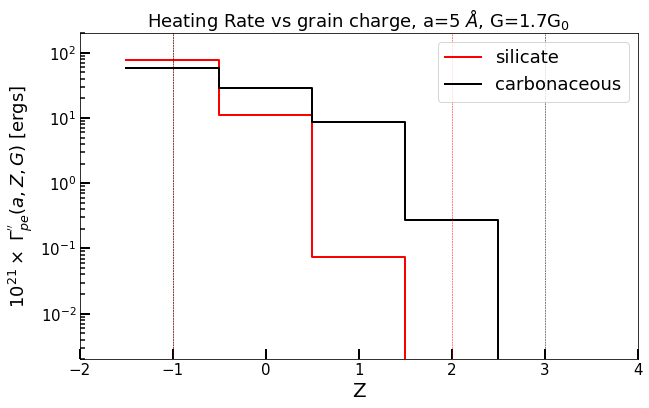

In [76]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

ax.plot(ZZ_sil+0.5, Gamma_dotdot_Z_sil*1.0e21, "-r", linewidth=2, linestyle="steps", label="silicate")
ax.plot(ZZ_carb+0.5, Gamma_dotdot_Z_carb*1.0e21, "-k", linewidth=2, linestyle="steps", label="carbonaceous")

ax.plot([Zmin_sil, Zmin_sil], [2.0e-3, 400], "--r", linewidth=0.5)
ax.plot([Zmax_sil, Zmax_sil], [2.0e-3, 400], "--r", linewidth=0.5)

ax.plot([Zmin_carb, Zmin_carb], [2.0e-3, 400], "--k", linewidth=0.5)
ax.plot([Zmax_carb, Zmax_carb], [2.0e-3, 400], "--k", linewidth=0.5)


ax.set_yscale("log")

ax.set_xlabel("Z", fontsize=20)
ax.set_ylabel("10$^{21} \\times$ $\Gamma^{''}_{pe}(a, Z, G)$ [ergs]", fontsize=18)

ax.set_xlim(min(Zmin_sil, Zmin_carb)-1, max(Zmax_sil, Zmax_carb)+1)

ax.set_ylim(2.0e-3, 200)

#ax.text(3, 100, "100 $\\AA$", fontsize=18)

ax.legend(loc=1, fontsize=18)

ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=15, direction="in")
ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=15, direction="in")

ax.set_title("Heating Rate vs grain charge, a=%i $\AA$, G=1.7G$_{0}$"%asize, fontsize=18)

fig.show()

##### Make the new plot for a different size.

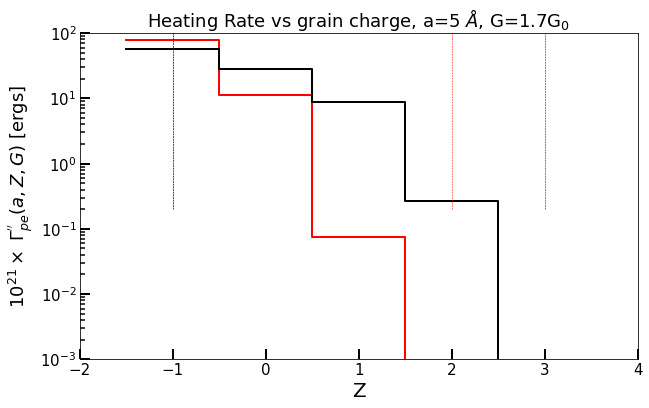

In [74]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

ax.plot(ZZ_sil+0.5, Gamma_dotdot_Z_sil*1.0e21, "-r", linewidth=2, linestyle="steps", label="silicate")
ax.plot(ZZ_carb+0.5, Gamma_dotdot_Z_carb*1.0e21, "-k", linewidth=2, linestyle="steps", label="carbonaceous")

ax.plot([Zmin_sil, Zmin_sil], [2.0e-1, 400], "--r", linewidth=0.5)
ax.plot([Zmax_sil, Zmax_sil], [2.0e-1, 400], "--r", linewidth=0.5)

ax.plot([Zmin_carb, Zmin_carb], [2.0e-1, 400], "--k", linewidth=0.5)
ax.plot([Zmax_carb, Zmax_carb], [2.0e-1, 400], "--k", linewidth=0.5)


ax.set_yscale("log")

ax.set_xlabel("Z", fontsize=20)
ax.set_ylabel("10$^{21} \\times$ $\Gamma^{''}_{pe}(a, Z, G)$ [ergs]", fontsize=18)

ax.set_xlim(min(Zmin_sil, Zmin_carb)-1, max(Zmax_sil, Zmax_carb)+1)

ax.set_ylim(1.0e-3, 1.0e2)

#ax.text(3, 100, "100 $\\AA$", fontsize=18)

#ax.legend(loc=0, fontsize=18)

ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=15, direction="in")
ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=15, direction="in")

ax.set_title("Heating Rate vs grain charge, a=%i $\AA$, G=1.7G$_{0}$"%asize, fontsize=18)

fig.show()

In [77]:
# Does this heating rate per charge scales linearly with the interstellar radiation field?

# Now varying the interstellar radiation field

In [93]:
asize = 5.
Zhere = 0.
Ntot = 0.0

In [103]:
Av = np.linspace(0, 10)
Ntot = np.zeros_like(Av)
GG = np.zeros_like(Av)

Ntot = 1.87e21*Av

for i in range(len(Av)):
    GG[i] = fz.get_G(Ntot[i], G0=1.7)

In [109]:
grain_type="silicate"
Qabs = fz.get_QabsTable(grain_type, asize)

Gamma_dotdot_G_sil = np.zeros_like(GG)
Gamma_dotdot_G_sil1 = np.zeros_like(GG)
Gamma_dotdot_G_siln1 = np.zeros_like(GG)

Gamma_dotdot_GforReal_sil = np.zeros_like(GG)

for i in range(len(GG)):
    Gamma_dotdot_G_sil[i] = get_Gamma_pe_dotdot(asize, 0., grain_type, Ntot[i], Qabs, G0=1.7)
    Gamma_dotdot_G_sil1[i] = get_Gamma_pe_dotdot(asize, 1., grain_type, Ntot[i], Qabs, G0=1.7)
    Gamma_dotdot_G_siln1[i] = get_Gamma_pe_dotdot(asize, -1., grain_type, Ntot[i], Qabs, G0=1.7)
    
    Gamma_dotdot_GforReal_sil[i] = get_Gamma_pe_dotdot(asize, 0., grain_type, 0.0, Qabs, G0=GG[i])
#Av = np.concatenate(([Zmin_sil-1], ZZ_sil))
#Gamma_dotdot_Z_sil = np.concatenate(([Gamma_dotdot_Z_sil[0]], Gamma_dotdot_Z_sil))

I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain


In [105]:
grain_type="carbonaceous"
Qabs = fz.get_QabsTable(grain_type, asize)

Gamma_dotdot_G_carb = np.zeros_like(GG)

for i in range(len(GG)):
    Gamma_dotdot_G_carb[i] = get_Gamma_pe_dotdot(asize, 0., grain_type, Ntot[i], Qabs, G0=1.7)
    
#Av = np.concatenate(([Zmin_sil-1], ZZ_sil))
#Gamma_dotdot_Z_sil = np.concatenate(([Gamma_dotdot_Z_sil[0]], Gamma_dotdot_Z_sil))

I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain


In [106]:
print(Gamma_dotdot_G_sil*1.0e21)

[1.11937265e+01 6.72041163e+00 4.03475397e+00 2.42235751e+00
 1.45431815e+00 8.73133408e-01 5.24205759e-01 3.14719006e-01
 1.88948807e-01 1.13439770e-01 6.81061796e-02 4.08891141e-02
 2.45487218e-02 1.47383908e-02 8.84853249e-03 5.31242036e-03
 3.18943397e-03 1.91485017e-03 1.14962442e-03 6.90203510e-04
 4.14379580e-04 2.48782329e-04 1.49362203e-04 8.96730402e-05
 5.38372759e-05 3.23224491e-05 1.94055270e-05 1.16505553e-05
 6.99467931e-06 4.19941689e-06 2.52121669e-06 1.51367053e-06
 9.08766980e-07 5.45599195e-07 3.27563048e-07 1.96660023e-07
 1.18069376e-07 7.08856706e-08 4.25578456e-08 2.55505832e-08
 1.53398813e-08 9.20965121e-09 5.52922631e-09 3.31959841e-09
 1.99299739e-09 1.19654191e-09 7.18371504e-10 4.31290884e-10
 2.58935420e-10 1.55457845e-10]


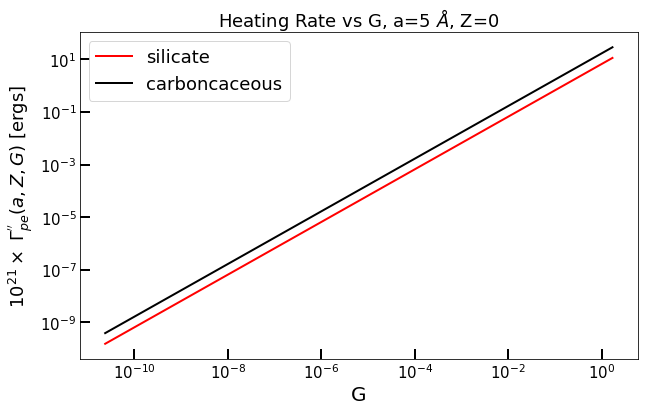

In [108]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

ax.plot(GG, Gamma_dotdot_G_sil*1.0e21, "-r", linewidth=2, label="silicate")
ax.plot(GG, Gamma_dotdot_G_carb*1.0e21, "-k", linewidth=2, label="carboncaceous")

ax.set_yscale("log")
ax.set_xscale("log")

ax.set_xlabel("G", fontsize=20)
ax.set_ylabel("10$^{21} \\times$ $\Gamma^{''}_{pe}(a, Z, G)$ [ergs]", fontsize=18)

#ax.set_xlim(min(Zmin_sil, Zmin_carb)-1, max(Zmax_sil, Zmax_carb)+1)

#ax.set_ylim(2.0e-1, 400)

#ax.text(3, 100, "100 $\\AA$", fontsize=18)

ax.legend(loc=2, fontsize=18)

ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=15, direction="in")
ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=15, direction="in")

ax.set_title("Heating Rate vs G, a=%i $\AA$, Z=0"%asize, fontsize=18)

fig.show()

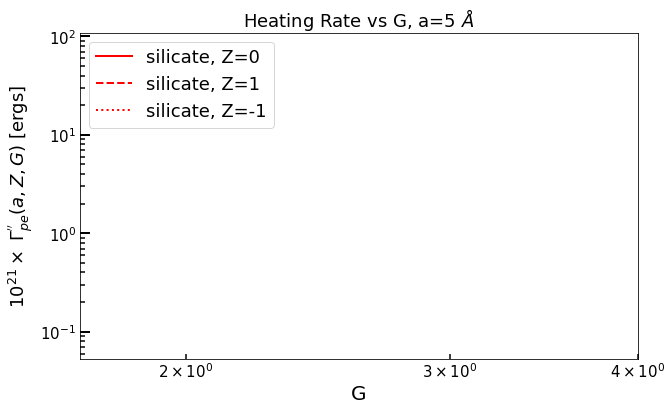

In [24]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

ax.plot(GG, Gamma_dotdot_G_sil*1.0e21, "-r", linewidth=2, label="silicate, Z=0")
ax.plot(GG, Gamma_dotdot_G_sil1*1.0e21, "--r", linewidth=2, label="silicate, Z=1")
ax.plot(GG, Gamma_dotdot_G_siln1*1.0e21, ":r", linewidth=2, label="silicate, Z=-1")

#ax.plot(GG, Gamma_dotdot_G_carb*1.0e21, "-k", linewidth=2, label="carboncaceous")

ax.set_yscale("log")
ax.set_xscale("log")

ax.set_xlabel("G", fontsize=20)
ax.set_ylabel("10$^{21} \\times$ $\Gamma^{''}_{pe}(a, Z, G)$ [ergs]", fontsize=18)

ax.set_xlim(min(Zmin_sil, Zmin_carb)-1, max(Zmax_sil, Zmax_carb)+1)

#ax.set_ylim(2.0e-1, 400)

#ax.text(3, 100, "100 $\\AA$", fontsize=18)

ax.legend(loc=2, fontsize=18)

ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=15, direction="in")
ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=15, direction="in")

ax.set_title("Heating Rate vs G, a=%i $\AA$"%asize, fontsize=18)

fig.show()

In [111]:
m = (np.log10(Gamma_dotdot_G_sil[0]) - np.log10(Gamma_dotdot_G_sil[-1]))/(np.log10(GG[0]) - np.log10(GG[-1]))
b = np.log10(Gamma_dotdot_G_sil[0]) - np.log10(GG[0])

In [112]:
bn1 = np.log10(Gamma_dotdot_G_siln1[0]) - np.log10(GG[0])

In [113]:
Gamma_scale = (GG / 1.0) * 10.**(b)

Gamma_scalen1 = (GG / 1.0) * 10.**(bn1)

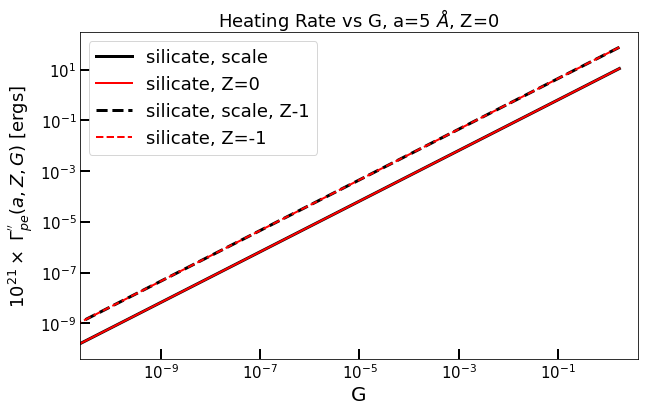

In [114]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

ax.plot(GG, Gamma_scale*1.0e21, "-k", linewidth=3, label="silicate, scale")
ax.plot(GG, Gamma_dotdot_G_sil*1.0e21, "-r", linewidth=2, label="silicate, Z=0")

ax.plot(GG, Gamma_scalen1*1.0e21, "--k", linewidth=3, label="silicate, scale, Z-1")
ax.plot(GG, Gamma_dotdot_G_siln1*1.0e21, "--r", linewidth=2, label="silicate, Z=-1")

ax.set_yscale("log")
ax.set_xscale("log")

ax.set_xlabel("G", fontsize=20)
ax.set_ylabel("10$^{21} \\times$ $\Gamma^{''}_{pe}(a, Z, G)$ [ergs]", fontsize=18)

ax.set_xlim(min(Zmin_sil, Zmin_carb)-1, max(Zmax_sil, Zmax_carb)+1)

#ax.set_ylim(2.0e-1, 400)

#ax.text(3, 100, "100 $\\AA$", fontsize=18)

ax.legend(loc=2, fontsize=18)

ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=15, direction="in")
ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=15, direction="in")

ax.set_title("Heating Rate vs G, a=%i $\AA$, Z=0"%asize, fontsize=18)

fig.show()

# heating at G=1.7, Z=0, varying size.

In [115]:
asize = np.logspace(np.log10(3.5), np.log10(2500), num=10)
Zhere = 0.
Ntot = 0.0

In [116]:
grain_type="silicate"

Gamma_dotdot_a_sil = np.zeros_like(asize)

for i in range(len(asize)):
    Qabs = fz.get_QabsTable(grain_type, asize[i])
    Gamma_dotdot_a_sil[i] = get_Gamma_pe_dotdot(asize[i], Zhere, grain_type, Ntot, Qabs, G0=1.7)

    
Gamma_dotdot_a_siln1 = np.zeros_like(asize)

for i in range(len(asize)):
    Qabs = fz.get_QabsTable(grain_type, asize[i])
    Gamma_dotdot_a_siln1[i] = get_Gamma_pe_dotdot(asize[i], -1, grain_type, Ntot, Qabs, G0=1.7)

    
Gamma_dotdot_a_sil1 = np.zeros_like(asize)

for i in range(len(asize)):
    Qabs = fz.get_QabsTable(grain_type, asize[i])
    Gamma_dotdot_a_sil1[i] = get_Gamma_pe_dotdot(asize[i], 1, grain_type, Ntot, Qabs, G0=1.7)


I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain
I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain
I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain
I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain
I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain
I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain


In [117]:
grain_type="carbonaceous"

Gamma_dotdot_a_carb = np.zeros_like(asize)

for i in range(len(asize)):
    Qabs = fz.get_QabsTable(grain_type, asize[i])
    Gamma_dotdot_a_carb[i] = get_Gamma_pe_dotdot(asize[i], Zhere, grain_type, Ntot, Qabs, G0=1.7)

Gamma_dotdot_a_carbn1 = np.zeros_like(asize)

for i in range(len(asize)):
    Qabs = fz.get_QabsTable(grain_type, asize[i])
    Gamma_dotdot_a_carbn1[i] = get_Gamma_pe_dotdot(asize[i], -1, grain_type, Ntot, Qabs, G0=1.7)

Gamma_dotdot_a_carb1 = np.zeros_like(asize)

for i in range(len(asize)):
    Qabs = fz.get_QabsTable(grain_type, asize[i])
    Gamma_dotdot_a_carb1[i] = get_Gamma_pe_dotdot(asize[i], 1, grain_type, Ntot, Qabs, G0=1.7)


I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain
I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain
I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain
I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain
I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain
I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain


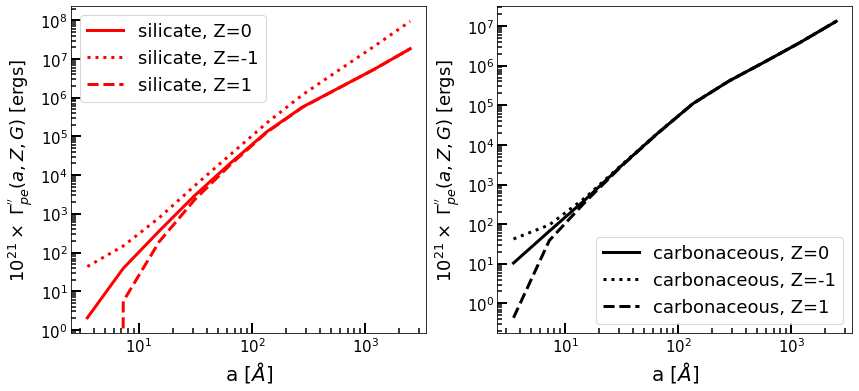

In [118]:
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(121)

ax.plot(asize, Gamma_dotdot_a_sil*1.0e21, "-r", linewidth=3, label="silicate, Z=0")
ax.plot(asize, Gamma_dotdot_a_siln1*1.0e21, ":r", linewidth=3, label="silicate, Z=-1")
ax.plot(asize, Gamma_dotdot_a_sil1*1.0e21, "--r", linewidth=3, label="silicate, Z=1")

ax.set_yscale("log")
ax.set_xscale("log")

ax.set_xlabel("a [$\AA$]", fontsize=20)
ax.set_ylabel("10$^{21} \\times$ $\Gamma^{''}_{pe}(a, Z, G)$ [ergs]", fontsize=18)

ax.legend(loc=0, fontsize=18)

ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=15, direction="in")
ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=15, direction="in")


ax = fig.add_subplot(122)

ax.plot(asize, Gamma_dotdot_a_carb*1.0e21, "-k", linewidth=3, label="carbonaceous, Z=0")
ax.plot(asize, Gamma_dotdot_a_carbn1*1.0e21, ":k", linewidth=3, label="carbonaceous, Z=-1")
ax.plot(asize, Gamma_dotdot_a_carb1*1.0e21, "--k", linewidth=3, label="carbonaceous, Z=1")
#ax.plot(GG, Gamma_dotdot_G_sil*1.0e21, "-r", linewidth=2, label="silicate, Z=0")


ax.set_yscale("log")
ax.set_xscale("log")

ax.set_xlabel("a [$\AA$]", fontsize=20)
ax.set_ylabel("10$^{21} \\times$ $\Gamma^{''}_{pe}(a, Z, G)$ [ergs]", fontsize=18)


#ax.set_ylim(2.0e-1, 400)

#ax.text(3, 100, "100 $\\AA$", fontsize=18)

ax.legend(loc=0, fontsize=18)

ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=15, direction="in")
ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=15, direction="in")

#ax.set_title("Heating Rate vs grain size, Z=0, G=1.7"%asize, fontsize=18)

fig.show()

# Now that I have the heating rates, I can multiply them with f(Z) to get the heating rate per grain.

    - read the charge distributions from my calculations.
    - sum over the charges times the heating per charge.

In [33]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from   matplotlib.colors import LogNorm

from scipy.optimize import curve_fit

import time

%matplotlib inline


grain_type = "silicate"
#grain_type = "carbonaceous"
pcent      = 1

########################################################################################

grain_size = 5

save_dir = "/home/jcibanezm/codes/run/ChargeStatisticsAnalysis/Daikaiju"
filename = "fz_%.4iAA_%s_CR_True_%i_pcent.pkl"%(grain_size, grain_type, pcent) 
#filename = "CompletenessCopy_0005AA_sil_CR.pkl"

pkl_file    = open("%s/%s"%(save_dir, filename), "rb")
cdist = pickle.load(pkl_file)
pkl_file.close

<function close>

In [34]:
#too_high = np.where(cdist["nH"] > 2.0e4)

#arrs = []

#ii = 0
#for key in cdist.keys():
    #arrs.append(0)
#    if key!="Qabs_mean" and key!="grain_size" and key!="grain_type" and key!="MPI" and key!="fdist" and key!="info" and key!="zminmax":
        #print(key)
#        cdist[key] = np.delete(cdist[key], too_high)

#cell_mass  = np.delete(cell_mass, too_high)

In [35]:
cdist["zmean"]

array([-0.13611121,  0.00341209, -0.19253396, ..., -0.02796377,
        0.03549214,  0.03818272])

## Heating per grain:

$$ \Gamma^{'}_{pe}(a) = \sum_{Z}f_{Z}(Z)\Gamma^{''}_{pe}(a,Z,G)$$

In [36]:
# Need to separate fZ for each grain.

In [37]:
#I could just compute Gamma_pe_a_Z for all possible Z's, and just give it to the function.
# Because if I have to loop over each grain and have to compute Gamma_pe_a_Z every time, it will take longer...

In [39]:
def Gamma_per_grain(ZZall, Gamma_a_Z, ZZ_fz, fz, GG):
    """
    Computes the heating rate per grain. Equation 38 in Weingartner and Draine 2001.
    This function requires the charge distribution function of the grain. 
    Internally computes the heating rate of the grain at each charge in the distribution.
    Then sums over the product of the charge PDF times heating(Z).
    
    input:
        asize: grain size in Angstroms.
        grain_type: carbonaceous or silicate
        ZZ: charge array
        fz: charge distribution function.
        GG: scaling of the radiation field
        
    return:
        Gamma_pe_a: Heating rate per grain, in units erg/s
    """
    
    # index in the ZZall array for the charges in ZZ_fz
    zi_down = np.where(ZZall == ZZ_fz[0])[0][0]# find the index of the ZZ_fz[0] in ZZall 
    zi_up   = np.where(ZZall == ZZ_fz[-1])[0][0]# find the index of the ZZ_fz[-1] in ZZall
    
    Gamma_pe_a = np.sum(fz*Gamma_a_Z[zi_down:zi_up+1])
    
    return Gamma_pe_a

In [52]:
index = 0

zmin = cdist["zminmax"][index]
zmax = cdist["zminmax"][index+1]
znum = int(abs(zmin) + zmax + 1)

GG = cdist["G"][index]

Ndust = cdist["Av"][index]*1.87e21

ZZfz = np.arange(zmin, zmax+1, 1)

ffz = cdist["fdist"][index:index+znum]

In [53]:
grain_type="silicate"
Qabs = fz.get_QabsTable(grain_type, grain_size)

Zmin_sil, Zmax_sil = fz.get_Zmin(grain_size, grain_type), fz.get_Zmax(grain_size, grain_type)
Znum_sil = int(Zmax_sil + abs(Zmin_sil) +1)
ZZ_sil = np.linspace(Zmin_sil, Zmax_sil, num=Znum_sil)

Gamma_dotdot_Z_sil = np.zeros_like(ZZ_sil)

for i in range(Znum_sil):
    Gamma_dotdot_Z_sil[i] = get_Gamma_pe_dotdot(grain_size, ZZ_sil[i], grain_type, Ndust, Qabs, G0=1.7)
    
#ZZ_sil = np.concatenate(([Zmin_sil-1], ZZ_sil))
#Gamma_dotdot_Z_sil = np.concatenate(([Gamma_dotdot_Z_sil[0]], Gamma_dotdot_Z_sil))

I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain


In [54]:
print(Gamma_dotdot_Z_sil)

[7.38968381e-21 1.06843565e-21 7.18403095e-24 0.00000000e+00]


I need to make this a function, that takes the grain size and composition, because I have to integrate this distribution.

I actually need to make the full function of the charging parameter where I give all the parameters:
    -nH
    -T
    -ne
    -Ntot
    -NH2

In [211]:
Gamma_a = np.zeros_like(cdist["zmean"])
zmean = np.zeros_like(Gamma_a)
cum = 0

#for index in range(100):
for index in range(len(Gamma_a)):
    
    zmin = cdist["zminmax"][index*2]
    zmax = cdist["zminmax"][index*2+1]
    znum = int(abs(zmin) + zmax + 1)

    GG = cdist["G"][index]
    
    Ndust = cdist["Av"][index]*1.87e21

    ZZfz = np.arange(zmin, zmax+1, 1)

    ffz = cdist["fdist"][cum:cum+znum]
    cum += znum
    
    zmean = np.sum(ZZfz*ffz)
    
    Gamma_a[index]= Gamma_per_grain(ZZ_sil, Gamma_dotdot_Z_sil, ZZfz, ffz, GG)
    #print(Gamma_a[index])

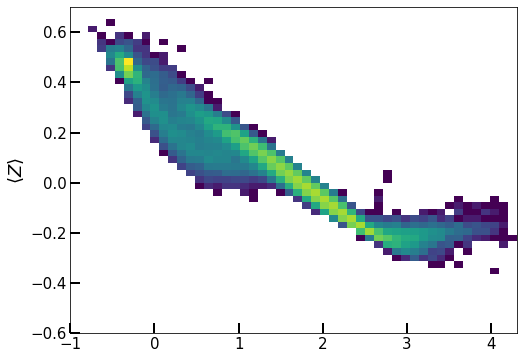

In [215]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

#ax.plot(cdist["nH"][0:len(Gamma_a)], Gamma_a*1.0e21, "-r", linewidth=3, label="silicate, Z=0")
#ax.scatter(cdist["nH"][0:len(Gamma_a)], Gamma_a*1.0e21)
#ax.hist2d(np.log10(cdist["nH"][0:len(Gamma_a)]), np.log10(Gamma_a), bins=50, norm=LogNorm(), cmap="viridis")
ax.hist2d(np.log10(cdist["nH"]),cdist["zmean"], bins=50, norm=LogNorm(), cmap="viridis", range=[[-1, 4.3],[-0.6, 0.7]])

#ax.set_yscale("log")
#ax.set_xscale("log")

#ax.set_xlabel("a [$\AA$]", fontsize=20)
ax.set_ylabel("$\\langle Z \\rangle$", fontsize=18)

#ax.legend(loc=0, fontsize=18)

ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=15, direction="in")
ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=15, direction="in")


#ax.set_title("Heating Rate vs grain size, Z=0, G=1.7"%asize, fontsize=18)

fig.show()

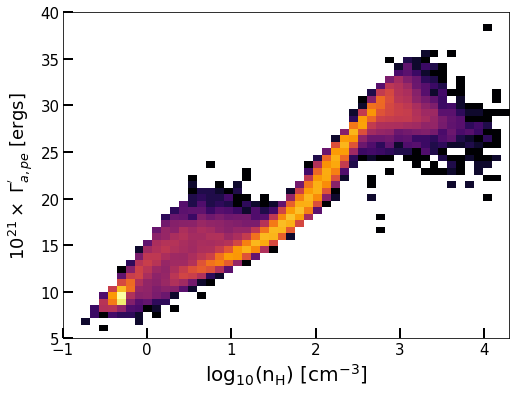

In [226]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

#ax.plot(cdist["nH"][0:len(Gamma_a)], Gamma_a*1.0e21, "-r", linewidth=3, label="silicate, Z=0")
#ax.scatter(cdist["nH"][0:len(Gamma_a)], Gamma_a*1.0e21)
#ax.hist2d(np.log10(cdist["nH"][0:len(Gamma_a)]), np.log10(Gamma_a), bins=50, norm=LogNorm(), cmap="viridis")
ax.hist2d(np.log10(cdist["nH"]),Gamma_a*1.0e21, bins=50, norm=LogNorm(), cmap="inferno", range=[[-1, 4.3],[5, 40]])

#ax.set_yscale("log")
#ax.set_xscale("log")

ax.set_xlabel("log$_{10}$(n$_{\mathrm{H}}$) [cm$^{-3}$]", fontsize=20)
ax.set_ylabel("10$^{21} \\times$ $\Gamma^{'}_{a, pe}$ [ergs]", fontsize=18)

#ax.legend(loc=0, fontsize=18)

ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=15, direction="in")
ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=15, direction="in")


#ax.set_title("Heating Rate vs grain size, Z=0, G=1.7"%asize, fontsize=18)

fig.show()

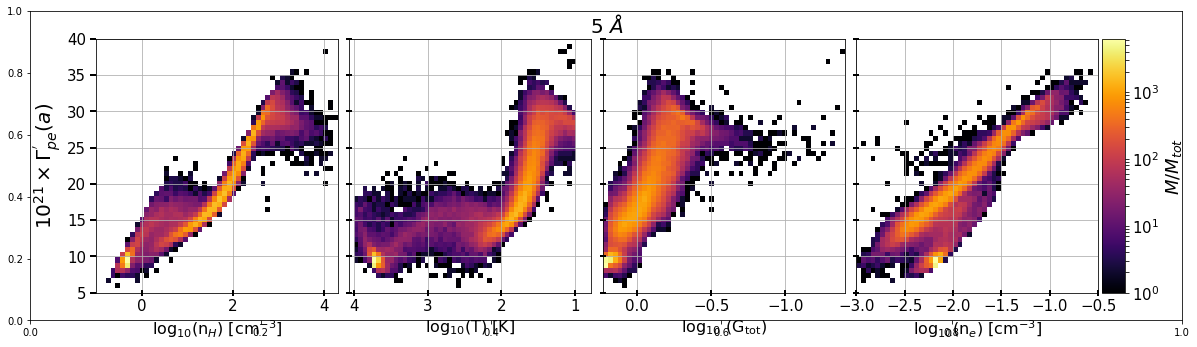

In [270]:
xsize = 16
ysize = 4.3

nfigs_x = 4
nfigs_y = 1

fig = plt.figure(figsize=(xsize, ysize))

hpad = 0.09
wpad = 0.057
wwpad = 0.01

xs_panel = 0.84 / nfigs_x 
ys_panel = 0.82 / nfigs_y 

#total_mass = np.sum(cell_mass_int)

############################################################################################################
############################             n          #######################################
############################################################################################################

ax = fig.add_axes([0, 0, 1, 1])

#ax.plot([0,1], [0,1], visible=False)
ax.set_xlim(0,1)
ax.set_ylim(0,1)

#ax.text(0.18, 0.955, "5 AA", fontsize=20, horizontalalignment='center')

#plt.axis('off')

#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 0
jj = 0


ax = fig.add_axes([wpad + ii*xs_panel, hpad + jj*ys_panel, xs_panel, ys_panel])

cax = ax.hist2d(np.log10(cdist["nH"]), Gamma_a*1.0e21, bins=50, norm=LogNorm(), cmap="inferno", range=[[-1, 4.3],[5, 40]])
#ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=15, direction="in")
#ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=15, direction="in")

ax.grid("on")

ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    direction= 'inout',
    labelbottom='on') # labels along the bottom edge are off

ax.set_ylabel("$10^{21} \\times \Gamma^{'}_{pe}(a)$", fontsize=20)
ax.set_xlabel("log$_{10}$(n$_{H}$) [cm$^{-3}$]", fontsize=16)

ax.tick_params(axis='x', which='both', bottom='on', labelbottom='on')
ax.tick_params(axis='both', which='major', length=6, width=2, labelsize=15)


############################################################################################################
############################                T          #######################################
############################################################################################################

#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 1
jj = 0

ax = fig.add_axes([wpad + ii*(xs_panel+wwpad), hpad + jj*ys_panel, xs_panel, ys_panel])

ax.hist2d(np.log10(cdist["temp"]), Gamma_a*1.0e21, bins=50, norm=LogNorm(), cmap="inferno", range=[[1, 4.0],[5, 40]])

#ax.hist2d(np.log10(cdist["temp"][0:len(cell_mass)]), cdist["zstd"][0:len(cell_mass)], bins=50, norm=LogNorm(), cmap="magma", weights=cell_mass/total_mass, vmin=1.0e-6, vmax=1.0e-1)
#ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=15, direction="in")
#ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=15, direction="in")

ax.grid("on")

ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    direction= 'inout',
    labelbottom='on', labelleft='off') # labels along the bottom edge are off


ax.set_xlabel("log$_{10}$(T) [K]", fontsize=16)

ax.set_xlim([np.max(np.log10(cdist["temp"])),np.min(np.log10(cdist["temp"]))])

ax.tick_params(axis='both', which='major', length=6, width=2, labelsize=15)




############################################################################################################
############################               G            #######################################
############################################################################################################

#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 2
jj = 0


ax = fig.add_axes([wpad + ii*(xs_panel+wwpad), hpad + jj*ys_panel, xs_panel, ys_panel])

# Missing G_CR
ax.hist2d(np.log10(cdist["G"]), Gamma_a*1.0e21, bins=50, norm=LogNorm(), cmap="inferno", range=[[-1.4, np.log10(1.7)],[5, 40]])

#cax = ax.hist2d(np.log10(cdist["G"][0:len(cell_mass)]+G_CR[0:len(cell_mass)]), cdist["zstd"][0:len(cell_mass)], bins=50, norm=LogNorm(), cmap="magma", weights=cell_mass/total_mass, vmin=1.0e-6, vmax=1.0e-1)
#ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=15, direction="in")
#ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=15, direction="in")

ax.grid("on")


ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    direction= 'inout',
    labelbottom='on', labelleft='off') # labels along the bottom edge are off


ax.set_xlabel("log$_{10}$ (G$_{\\mathrm{tot}}$)", fontsize=16)

#ax.set_xlim([np.log10(1.7),np.min(np.log10(cdist["G"]))])
ax.set_xlim(np.log10(1.7),-1.4)

ax.tick_params(axis='both', which='major', length=6, width=2, labelsize=15)


############################################################################################################
############################               ne            #######################################
############################################################################################################

#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 3
jj = 0


ax = fig.add_axes([wpad + ii*(xs_panel+wwpad), hpad + jj*ys_panel, xs_panel, ys_panel])

ax.hist2d(np.log10(cdist["ne"]), Gamma_a*1.0e21, bins=50, norm=LogNorm(), cmap="inferno", range=[[-3, -0.5],[5, 40]])

#Gamma_a*1.0e21, bins=50, norm=LogNorm(), cmap="", weights=cell_mass/total_mass, vmin=1.0e-6, vmax=1.0e-1)
#ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=15, direction="in")
#ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=15, direction="in")

ax.grid("on")

ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    direction= 'inout',
    labelbottom='on', labelleft='off') # labels along the bottom edge are off

ax.set_xlabel("log$_{10}$(n$_{e}$) [cm$^{-3}$]", fontsize=16)


ax.tick_params(axis='both', which='major', length=6, width=2, labelsize=15)



#################################################################################################
# Add colorbar.
cbar_ax = fig.add_axes([0.93, 0.09, 0.02, 0.82])
cbar    = fig.colorbar(cax[3], cax=cbar_ax, orientation="vertical")

cbar.set_label("$M/M_{tot}$", fontsize=18, labelpad=5)
cbar.ax.tick_params(labelsize=15)

fig.suptitle("%i $\\AA$"%(cdist["grain_size"]), fontsize=20, y=0.99)

fig.show()

## Now, integrate over the size distribution

$$ \frac{\Gamma_{tot}}{G n_{\mathrm{H}}} = \sum_{c,s} \int_{a_{min}}^{a_{max}} \frac{\Gamma^{'}_{pe} - \Lambda^{'}_{gr}}{G} \frac{1}{n_{\mathrm{H}}} \frac{dn_{gr}}{da} da $$